In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
#from pysynphot import spectrum as S
from glob import glob

import limbdark as ld

import scipy
from scipy.optimize import minimize
from scipy.constants import k,c,h
from scipy import integrate

from astropy import units as u
from astropy import constants as const
from astropy.constants import G,R_jup,R_sun,M_jup,M_sun,au,pc,sigma_sb

# Definition and filter settings

In [2]:
def _bb(lam,T):
    '''
    Planck's law[W/m**2/m/sr] with fixed temperature
    [input]
    T: star's effective temperature
    '''    
    B_lambda = (2*h*(np.power(c,2)) )/ (np.power(lam,5) * (np.exp(h*c/ (lam*k*T)) - 1))
    
    return B_lambda


def _bb_f(lam,T):
    '''
    Planck's law[W/m**2/Hz/sr] with fixed temperature
    [input]
    temp: star's effective temperature
    '''    
    nu = c/lam
    B_freq = 2*h*nu**3 / (c**2 * (np.exp(h*nu/ (k*T)) - 1))
    
    return B_freq



def _ABmag(temp,r_s,dist):
    '''
    AB mag calculator for Johnson B,I,R,V and Kepler
    note(210727): need to prepare the filters before running this function 
    
    [Input]
    temp:effective temperature of the star[K]
    r_s: stellar radius[R_sun]
    dist: distance from the star to the Earth[m]
    '''
    
    mags = []
    for b in bands:
        lam = filt[b][0] * 1e-10
        for i in range(len(filt[b])):
            nu = []
            ar_freq = []
            ar_bb_freq = []
            ar_median = []
            ar_freq = np.linspace(lam[i]-100e-10, lam[i]+100e-10, 10)
            ar_bb_freq = np.empty(len(ar_freq))
            
            for j in range(len(ar_freq)):
                ar_bb_each = []
                ar_bb_each.append(_bb_f(ar_freq[j],temp))
            ar_median.append(np.median(ar_bb_each))
        nume = math.fsum(ar_median*filt[b][1]/(c/lam))
        denomi = math.fsum(filt[b][1]/(c/lam))
        # ' *1e3' means watt to erg/s 
        mag = -2.5 * np.log10(nume/denomi * (r_s*R_sun/dist)**2 * np.pi * 1e3) - 48.6
        mags.append(mag)
    return mags


#The following functions are used to check that the above functions are correct

def blackbody(temp,lam):
    '''
    Planck's law[W/m**2/m/sr][W/m**2/Hz/sr]  
    [input]
    temp: star's effective temperature
    lam: wavelength[m]
    [return]
    B_lambda:the spectral radiance of a body for wavelength
    B_freq:the spectral radiance of a body for frequency
    '''
    #frequency
    nu = c/lam
    B_lambda = 2*h*c**2 / (lam**5 * (np.exp(h*c/ (lam*k*temp)) - 1))
    B_freq = 2*h*nu**3 / (c**3 * (np.exp(h*nu/(k*temp)) - 1))
    return B_lambda, B_freq


def sb(temp):
    '''
    Stefan–Boltzmann law[W] 
    [input]
    temp: star's effective temperature
    '''
    rad = sigma_sb * temp**4
    return rad


['./Generic_Johnson.B.dat', './Generic_Johnson.I.dat', './Generic_Johnson.R.dat', './Generic_Johnson.V.dat', './Kepler_Kepler.K.dat']


Text(0.5, 0, 'wavelength[m]')

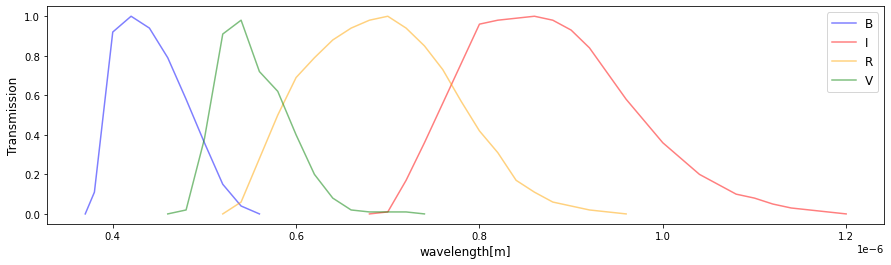

In [3]:
datadir = '.'
path    = os.path.join(datadir,'*.dat')
file_list = glob(path)
file_list = sorted(file_list)
print(file_list)

filt={}
bands = 'B,I,R,V'.split(',')
for fname,b in zip(file_list,bands):
    df=pd.read_table(fname, delimiter=' ', parse_dates=True, header=None)
    #df = df.drop('Unnamed: 0',axis=1)
    #df = df.set_index('GJD-2450000')
    filt[b] = df
filt.keys()

lam_col =  'lambda'
trans_col  =  'transmission'

colors='b,r,orange,g,black'.split(',')
fig,ax = plt.subplots(1,1,figsize=(15,4))

n=0
for b,co in zip(bands,colors):
    df = filt[b]    
    lam_nm = df[0]*1e-10
    trans = df[1]
    
    ax.plot(lam_nm, trans, label=b, color=co, alpha=0.5)
    ax.set_ylabel('Transmission', fontsize=12)
    n+=1
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('wavelength[m]',fontsize=12)

# Test

## calculate the Sun's AB mag in V-band witn transmittance=100%   
Literature: -26.77mag

In [4]:
# AB mag/ the Sun/ transmission=100%/ V mag
T = 3000

B_freq_syn = lambda nu: 2*h*nu**3 / (c**2 * (np.exp(h*nu/ (k*T)) - 1))/nu
freq_syn = lambda nu: 1/nu

f_sun_syn, f_sun_syn_err = integrate.quad(B_freq_syn, c/7.4e-7, c/4.6e-6)
f_syn,f_syn_err = integrate.quad(freq_syn, c/7.4e-7, c/4.6e-6)

m = -2.5 * np.log10(f_sun_syn/f_syn * (R_sun/au)**2 * np.pi * 1e3) - 48.6
print(' V mag = {:}\n'.format(m))

 V mag = -24.63542840049576



## calculate the Sun's AB mag in B, I, R, V, Kepler mag   
[reference](https://iopscience.iop.org/article/10.3847/1538-4365/aabfdf)     
Johnson B: −26.26   
Cousins_I: −27.06    
Cousins_R: −26.97    
Johnson V: −26.77    

In [5]:
sun_mag = _ABmag(5700, 1.0, au)
print(bands)
print(sun_mag)

['B', 'I', 'R', 'V']
[<Quantity -26.71405825>, <Quantity -26.93624222>, <Quantity -27.03559216>, <Quantity -26.99922199>]


## Various stars

## R=2R_sun, T=3000K, distance=145pc

In [6]:

dmtau_mag = _ABmag(3000, 2.0, 145*pc)
print(dmtau_mag)

[<Quantity 13.49978757>, <Quantity 11.09915377>, <Quantity 11.45686821>, <Quantity 12.19964489>]


# Grid model

In [7]:
class Mesh2D:
    def __init__(self, xrange, yrange, n):
        self.n = n
        self.x_min = xrange[0]
        self.x_max = xrange[1]
        self.y_min = yrange[0]
        self.y_max = yrange[1]
        self.x = np.linspace(xrange[0], xrange[1], n)
        self.y = np.linspace(yrange[0], yrange[1], n)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        
def _g(x, y, us, I_mean):
    #mu = cos(theta)
    u1,u2 = us

    mu = np.sqrt(1-(x**2+y**2))
    I_mu = (1 - u1*(1-mu) - u2*(1-mu)**2) * I_mean
    
    I_mu[np.isnan(I_mu)] = 0.
    return I_mu

def _ldc(ld_params, band, law='quadratic'):
    '''
    calculate limb-darkening coefficients
    
    [Input]
    ld_params :list of the parameters to calculate LDCs. [teff, uteff, logg, ulogg, feh, ufeh]
    band: filter name (ex. 'V' 'r*')
    '''
    teff, uteff, logg, ulogg, feh, ufeh = ld_params
    ldc_list     = []
    ldc_err_list = []
    ldp = []
    
    ldc = ld.claret(band, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4), law=law)
    ldp.append(ldc)
    #u1,u2
    ldc_list=[ldc[0],ldc[2]] #take first and third element of ldc 
    #uncertainties
    ldc_err_list=[ldc[1],ldc[3]] #take second and fourth element of ldc
    
    return ldc_list

def _band_intensity(temp, filt):
    '''
    calculate mean intensity
    ref: Bessell(2011) eq.(A12)
    
    [Input]
    temp: effective temperature of the star[K]
    filt: filter profile downloaded from SVO filter profile
    '''
    lam = filt[0] * 1e-10
    bb_freq_med = []
    
    for i in range(len(filt)):
        nu = []
        ar_freq = []
        ar_bb_freq = []
        ar_freq = np.linspace(lam[i]-100e-10, lam[i]+100e-10, 10)
        ar_bb_freq = np.empty(len(ar_freq))
        for j in range(len(ar_freq)):
            ar_bb = []
            ar_bb = _bb_f(ar_freq[j],temp)
        bb_freq_med = np.median(ar_bb)

    nume = math.fsum(bb_freq_med*filt[1]/(c/lam))
    denomi = math.fsum(filt[1]/(c/lam))
    mean_intensity = nume/denomi
    
    return mean_intensity

## test with a solor like star (d=1au,R_s=R_sun)

<ipython-input-7-ee3945d88b80>:16: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(x**2+y**2))


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


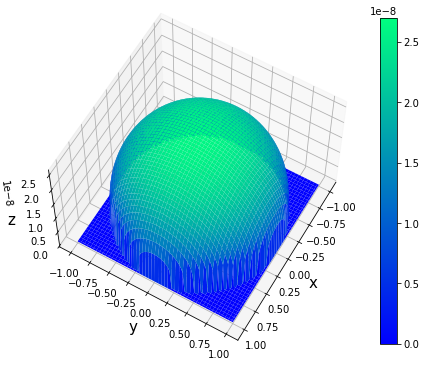

In [15]:
params = [5711, 90, 4.470, 0.054, -0.01, 0.14]
ldcs = _ldc(params, 'B')
I_mean = _band_intensity(5711,filt['B'])
ngrid = 100

m = Mesh2D([-1,1], [-1, 1], ngrid)
Z = _g(m.X, m.Y, ldcs, I_mean)
print(Z)

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection="3d")

# 3DAxes
ax.set_xlabel("x", size = 15)
ax.set_ylabel("y", size = 15)
ax.set_zlabel("z", size = 15)
ax.view_init(60, 30)

p = ax.plot_surface(m.X, m.Y, Z, cmap = "winter", vmin=0, vmax=2.7e-8)
fig.colorbar(p)


plt.show()

In [16]:
sum_intensity_x = []
for i in range(len(Z)):
    sum_intensity_x.append(math.fsum(Z[i]))
sum_intensity = math.fsum(sum_intensity_x)
sun_test_flux = np.pi * sum_intensity/(ngrid**2) * 1/2 * (-math.cos(2*math.asin(R_sun/au)) + 1)
-2.5 * np.log10(sun_test_flux*1e3)- 48.6

-26.128150204451075

## test with Trappist1

<ipython-input-7-ee3945d88b80>:16: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(x**2+y**2))


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


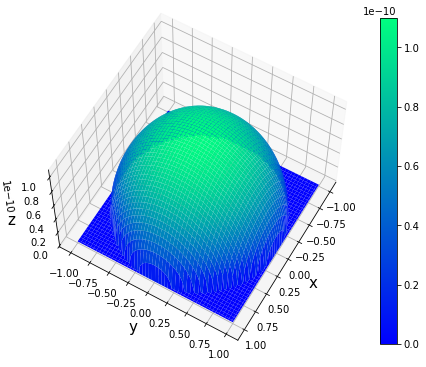

In [17]:
t_trappist = 2550
d_trappist = 12.4 #pc
rs_trappist = 0.12 #R_s
params = [t_trappist, 55, 5.2759, 0.07, 0.04, 0.08]
ldcs = _ldc(params, 'B')
I_mean = _band_intensity(t_trappist,filt['B'])
ngrid = 100

m = Mesh2D([-1,1], [-1, 1], ngrid)
Z = _g(m.X, m.Y, ldcs, I_mean)
print(Z)

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection="3d")

# 3DAxes
ax.set_xlabel("x", size = 15)
ax.set_ylabel("y", size = 15)
ax.set_zlabel("z", size = 15)
ax.view_init(60, 30)

p = ax.plot_surface(m.X, m.Y, Z, cmap = "winter", vmin=0, vmax=1.1e-10)
fig.colorbar(p)


plt.show()

In [36]:
sum_intensity_x = []
for i in range(len(Z)):
    sum_intensity_x.append(math.fsum(Z[i]))
sum_intensity = math.fsum(sum_intensity_x)
sun_test_flux = np.pi * sum_intensity/(ngrid**2) * (math.sin(math.asin(rs_trappist*R_sun/(d_trappist*pc))))**2
-2.5 * np.log10(sun_test_flux*1e3)- 48.6

16.613311615318487

### comment@210823: trigonometric function problem???